<a href="https://colab.research.google.com/github/salmanarif86/MLAI/blob/master/Pytorch_Resnet_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension
%load_ext tensorboard

In [0]:
pip uninstall tb-nightly

In [0]:
import os
logs_base_dir = "runs"
os.makedirs(logs_base_dir, exist_ok=True)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
torch.set_printoptions(profile="full") 

In [0]:
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
#class torchvision.transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2)
#transforms.RandomResizedCrop(224) --> A crop of random size (default: of 0.08 to 1.0) of the original size and a 
#random aspect ratio (default: of 3/4 to 4/3) of the original aspect ratio is made. 
#This crop is finally resized to given size (224 in this case). 
#transforms.CenterCrop(224)--> Crops the image at the center. 224 is the Desired output size of the crop.
#class torchvision.transforms.Normalize(mean, std)
#Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels, 
#this transform will normalize each channel of the input torch.Tensor i.e. 
#input[channel] = (input[channel] - mean[channel]) / std[channel]
#Parameters:     mean (sequence) – Sequence of means for each channel.
#                std (sequence) – Sequence of standard deviations for each channel.
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)


In [0]:
data_dir = r'/content/drive/My Drive/Fruit'
#Create a dictionary that contains the information of the images in both the training and validation set
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}
#Create a dictionary that contians the data loader


In [0]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=32,
                                              shuffle=True, num_workers=10) for x in ['train', 'val']}

#Create a dictionary that contains the size of each dataset (training and validation)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
#Get the class names
class_names = image_datasets['train'].classes
#Print out the results 
print("Class Names: {}".format(class_names))
print('\n')
print('******Summary Statistics of our Data********')
print('\n')
print("There are {} classes in the data set".format(len(class_names)))
print("There are {} batches in the training set".format(len(dataloaders['train'])))
print("There are {} batches in the test set".format(len(dataloaders['val'])))
print("There are {} training images".format(dataset_sizes['train']))
print("There are {} testing images".format(dataset_sizes['val']))

Class Names: ['Apple Braeburn', 'Apple Golden 1', 'Apple Granny Smith', 'Apple Red 1', 'Apple Red Delicious', 'Apple Red Yellow', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Red', 'Cactus fruit', 'Cantaloupe 1', 'Carambula', 'Cherry 1', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Clementine', 'Cocos', 'Dates', 'Granadilla', 'Grape Pink', 'Grape White', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Huckleberry', 'Kaki', 'Kiwi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Maracuja', 'Melon Piel de Sapo', 'Mulberry', 'Nectarine', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Peach Flat', 'Pear', 'Pear Abate', 'Pear Monster', 'Pear Williams', 'Pepino', 'Physalis', 'Physalis with Husk', 'Pineapple', 'Pineapple Mini', 'Pitahaya Red', 'Plum', 'Pomegranate', 'Quince', 'Rambutan', 'Raspberry', 'Salak', 'Strawberry', 'Strawberry Wedge', 'Tamarillo', 'Tangelo', 'Tomato 1', 'Tomato Cherry Red', 'Tomato Maroon', 'Wa

In [0]:
image, label = image_datasets['train'][987]
image_test, label_test = image_datasets['val'][987]
print(image)
print(f'The targer for the above image is {label}')
print(f'The shape  of our dataset is {image.shape}')
print('\n')
print(f'The targer for the above image is {label_test}')
print(f'The shape  of our dataset is {image_test.shape}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


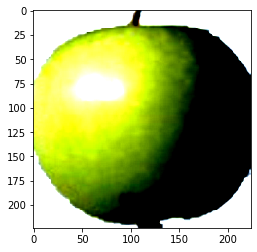

In [0]:
plt.imshow(np.transpose(image.numpy(),(1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pear Abate
Tamarillo
Banana
Orange
Quince
Papaya
Papaya
Kumquats
Tomato 1
Orange
Banana Red
Pear Monster
  [48 65  9 42 59 43 43 31 67 42 10 49]


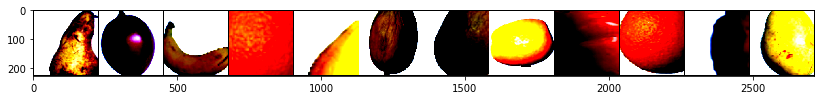

In [0]:
for images,labels in dataloaders['train']: 
    break
# Print the first 12 labels
for label in labels[:12].numpy():
    print(image_datasets['train'].classes[label])

# Print the first 12 labels indicies
print(' ', labels[:12].numpy())


# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(14,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [0]:
#Load the ResNet
model_conv = torchvision.models.resnet18(pretrained=True).cuda()

In [0]:
next(model_conv.parameters()).is_cuda

True

In [0]:
for param in model_conv.parameters():  
    param.requires_grad = False

In [0]:
#Get the number of inputs of the last layer (or number of neurons in the layer preceeding the last layer)
num_ftrs = model_conv.fc.in_features
#Reconstruct the last layer with 71 classes 
model_conv.fc = nn.Linear(num_ftrs, 71).cuda()

In [0]:
iteration = 0
correct = 0
for inputs,labels in dataloaders['train']:
    if iteration==1:
        break
    inputs = Variable(inputs)
    labels = Variable(labels)
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
    print("For one iteration, this is what happens:")
    print("Input Shape:",inputs.shape)
    print("Labels Shape:",labels.shape)
    print("Labels are: {}".format(labels))
    output = model_conv(inputs)
    print("Output Tensor:", output)
    print("Outputs Shape",output.shape)
    _, predicted = torch.max(output, 1)
    print("Predicted:", predicted)
    print("Predicted Shape",predicted.shape)
    correct += (predicted == labels).sum()   
    print("Correct Predictions:",correct)
    
    iteration += 1

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
#Try experimenting with: optim.Adam(model_conv.fc.parameters(), lr=0.001)
#Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
num_epochs = 2

train_losses =[]
test_losses =[]
train_correct =[]
test_correct =[]

images, labels = next(iter(dataloaders['train']))
images = images.cuda()
labels = labels.cuda()
grid = torchvision.utils.make_grid(images)


tb = SummaryWriter()
tb.add_image('images',grid)
tb.add_graph(model_conv, images)


for epoch in range (num_epochs):

    exp_lr_scheduler.step()
    #Reset the correct to 0 after passing through all the dataset
    
    correct = 0
    

    for b, (images,labels) in enumerate(dataloaders['train']):

        b+=1

        
        images = Variable(images)
        labels = Variable(labels)
        
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            
        optimizer.zero_grad()
        outputs = model_conv(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()  
        
        _, predicted = torch.max(outputs, 1) 
        correct += (predicted == labels).sum()
        
        
        if b%10==0:
          train_acc = correct.item() * 100/(b * 32)
          print(f'EPOCH: {epoch:2}  BATCH {b:4}/1120    LOSS {loss.item():10.8f}, CORRECT{correct}  ACCURACY {train_acc:7.3f}%')
      
    tb.add_scalar('Loss', loss, epoch)
    tb.flush()
    tb.add_scalar('Number of correct', correct, epoch )
    tb.add_scalar('Accuracy', correct/len(dataloaders['train']), epoch )

    
    tb.add_histogram(f'fc.bias', model_conv.fc.bias, epoch)
    tb.add_histogram(f'fc.weight', model_conv.fc.weight, epoch)
    tb.add_histogram(f'fc.grad', model_conv.fc.weight.grad, epoch)
tb.close()




        


EPOCH:  0  BATCH   10/1120    LOSS 3.02725148, CORRECT145  ACCURACY  45.312%
EPOCH:  0  BATCH   20/1120    LOSS 2.74610615, CORRECT304  ACCURACY  47.500%
EPOCH:  0  BATCH   30/1120    LOSS 2.68849754, CORRECT463  ACCURACY  48.229%
EPOCH:  0  BATCH   40/1120    LOSS 2.86445379, CORRECT639  ACCURACY  49.922%
EPOCH:  0  BATCH   50/1120    LOSS 2.88607812, CORRECT797  ACCURACY  49.812%
EPOCH:  0  BATCH   60/1120    LOSS 2.68028545, CORRECT980  ACCURACY  51.042%
EPOCH:  0  BATCH   70/1120    LOSS 2.48357153, CORRECT1156  ACCURACY  51.607%
EPOCH:  0  BATCH   80/1120    LOSS 2.85911369, CORRECT1325  ACCURACY  51.758%
EPOCH:  0  BATCH   90/1120    LOSS 2.67646384, CORRECT1507  ACCURACY  52.326%
EPOCH:  0  BATCH  100/1120    LOSS 2.42258859, CORRECT1686  ACCURACY  52.688%
EPOCH:  0  BATCH  110/1120    LOSS 2.40795517, CORRECT1893  ACCURACY  53.778%
EPOCH:  0  BATCH  120/1120    LOSS 2.33171749, CORRECT2083  ACCURACY  54.245%
EPOCH:  0  BATCH  130/1120    LOSS 2.35839939, CORRECT2289  ACCURACY  

In [0]:
%tensorboard --logdir {logs_base_dir}

Reusing TensorBoard on port 6006 (pid 4547), started 0:54:16 ago. (Use '!kill 4547' to kill it.)

<IPython.core.display.Javascript object>

In [0]:
# Test the model
model_conv.eval()  
with torch.no_grad():
    correct = 0
    total = 0
    for (images, labels) in dataloaders['val']:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model_conv(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        
        

    print('Test Accuracy: {:.3f} %'.format(100 * correct / total))

Test Accuracy: 97.782 %


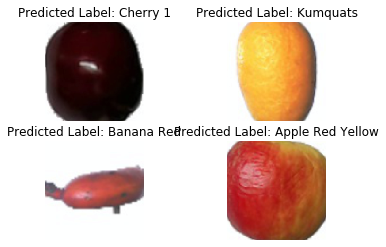

In [0]:

#Visualize some predictions 
import matplotlib.pyplot as plt
fig = plt.figure()
shown_batch = 0
index = 0
with torch.no_grad():
    for (images, labels) in dataloaders['val']:
        if shown_batch == 1:
            break
        shown_batch += 1
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model_conv(images)                            #The output is of shape (4,2)
        _, preds = torch.max(outputs, 1)                        #The pred is of shape (4) --> [ 0,  0,  0,  1]
        
        for i in range(4):
            index += 1
            ax = plt.subplot(2,2,index)
            ax.axis('off')
            ax.set_title('Predicted Label: {}'.format(class_names[preds[i]]))
            input_img = images.cpu().data[i]                    #Get the tensor of the image, and put it to cpu  
            inp = input_img.numpy().transpose((1, 2, 0))        #If we have a tensor of shape (2,3,4) --> it becomes (3,4,2)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            plt.imshow(inp)

In [0]:
dataset_sizes['train']

35819

In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

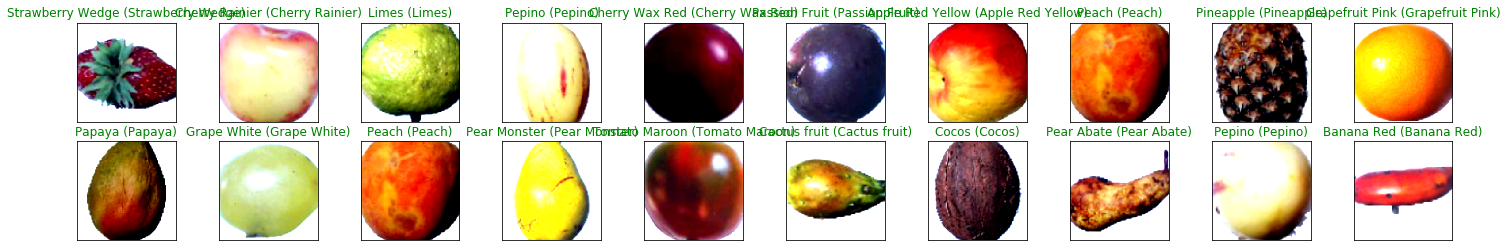

In [0]:
dataiter = iter(dataloaders['val'])
images, labels = dataiter.next()
images = images.cuda()
labels = labels.cuda()
output = model_conv(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(class_names[preds[idx].item()]), str(class_names[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

In [0]:
nb_classes = 71

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.cuda()
        classes = classes.cuda()
        outputs = model_conv(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

In [0]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([1.0000, 0.9939, 1.0000, 0.8049, 1.0000, 1.0000, 0.9146, 0.9930, 1.0000,
        0.9880, 0.9940, 1.0000, 1.0000, 1.0000, 0.9817, 0.9228, 1.0000, 1.0000,
        1.0000, 0.9880, 0.9940, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9756,
        1.0000, 1.0000, 0.8614, 1.0000, 1.0000, 0.9268, 1.0000, 0.9819, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8902, 1.0000, 1.0000, 0.9880,
        0.6768, 0.9756, 0.9756, 1.0000, 1.0000, 1.0000, 0.9759, 1.0000, 1.0000,
        1.0000, 0.9693, 1.0000, 1.0000, 0.9451, 1.0000, 0.9878, 1.0000, 1.0000,
        1.0000, 0.9024, 0.9819, 0.8795, 1.0000, 1.0000, 0.9921, 1.0000])
